## Train Model

In [ ]:

from ultralytics import YOLO

# Load a pretrained model
model = YOLO("yolo11s-obb.pt")

# Train the model on the custom dataset
results = model.train(data="dataset/ellipse_recognition/ellipse_recognition.yml", epochs=250, imgsz=640)


## Convert the model to ONNX format for use in C++

In [1]:
from ultralytics import YOLO # if not already imported

training_run = 11

model = YOLO(f'runs/obb/train{str(training_run)}/weights/best.pt')

print(model.model)

model.export(format="onnx", imgsz=640, dynamic=False, nms=True)

OBBModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (

'runs/obb/train11/weights/best.onnx'

## Load sample image in onnx format


image 1/1 /home/paul/akamav/dev/ellipse_pose_estimation_py/test1.jpg: 640x640 148.7ms
Speed: 1.0ms preprocess, 148.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
tensor([[[222.2234, 340.9869],
         [406.2456, 335.0195],
         [402.0477, 205.5636],
         [218.0255, 211.5310]]])


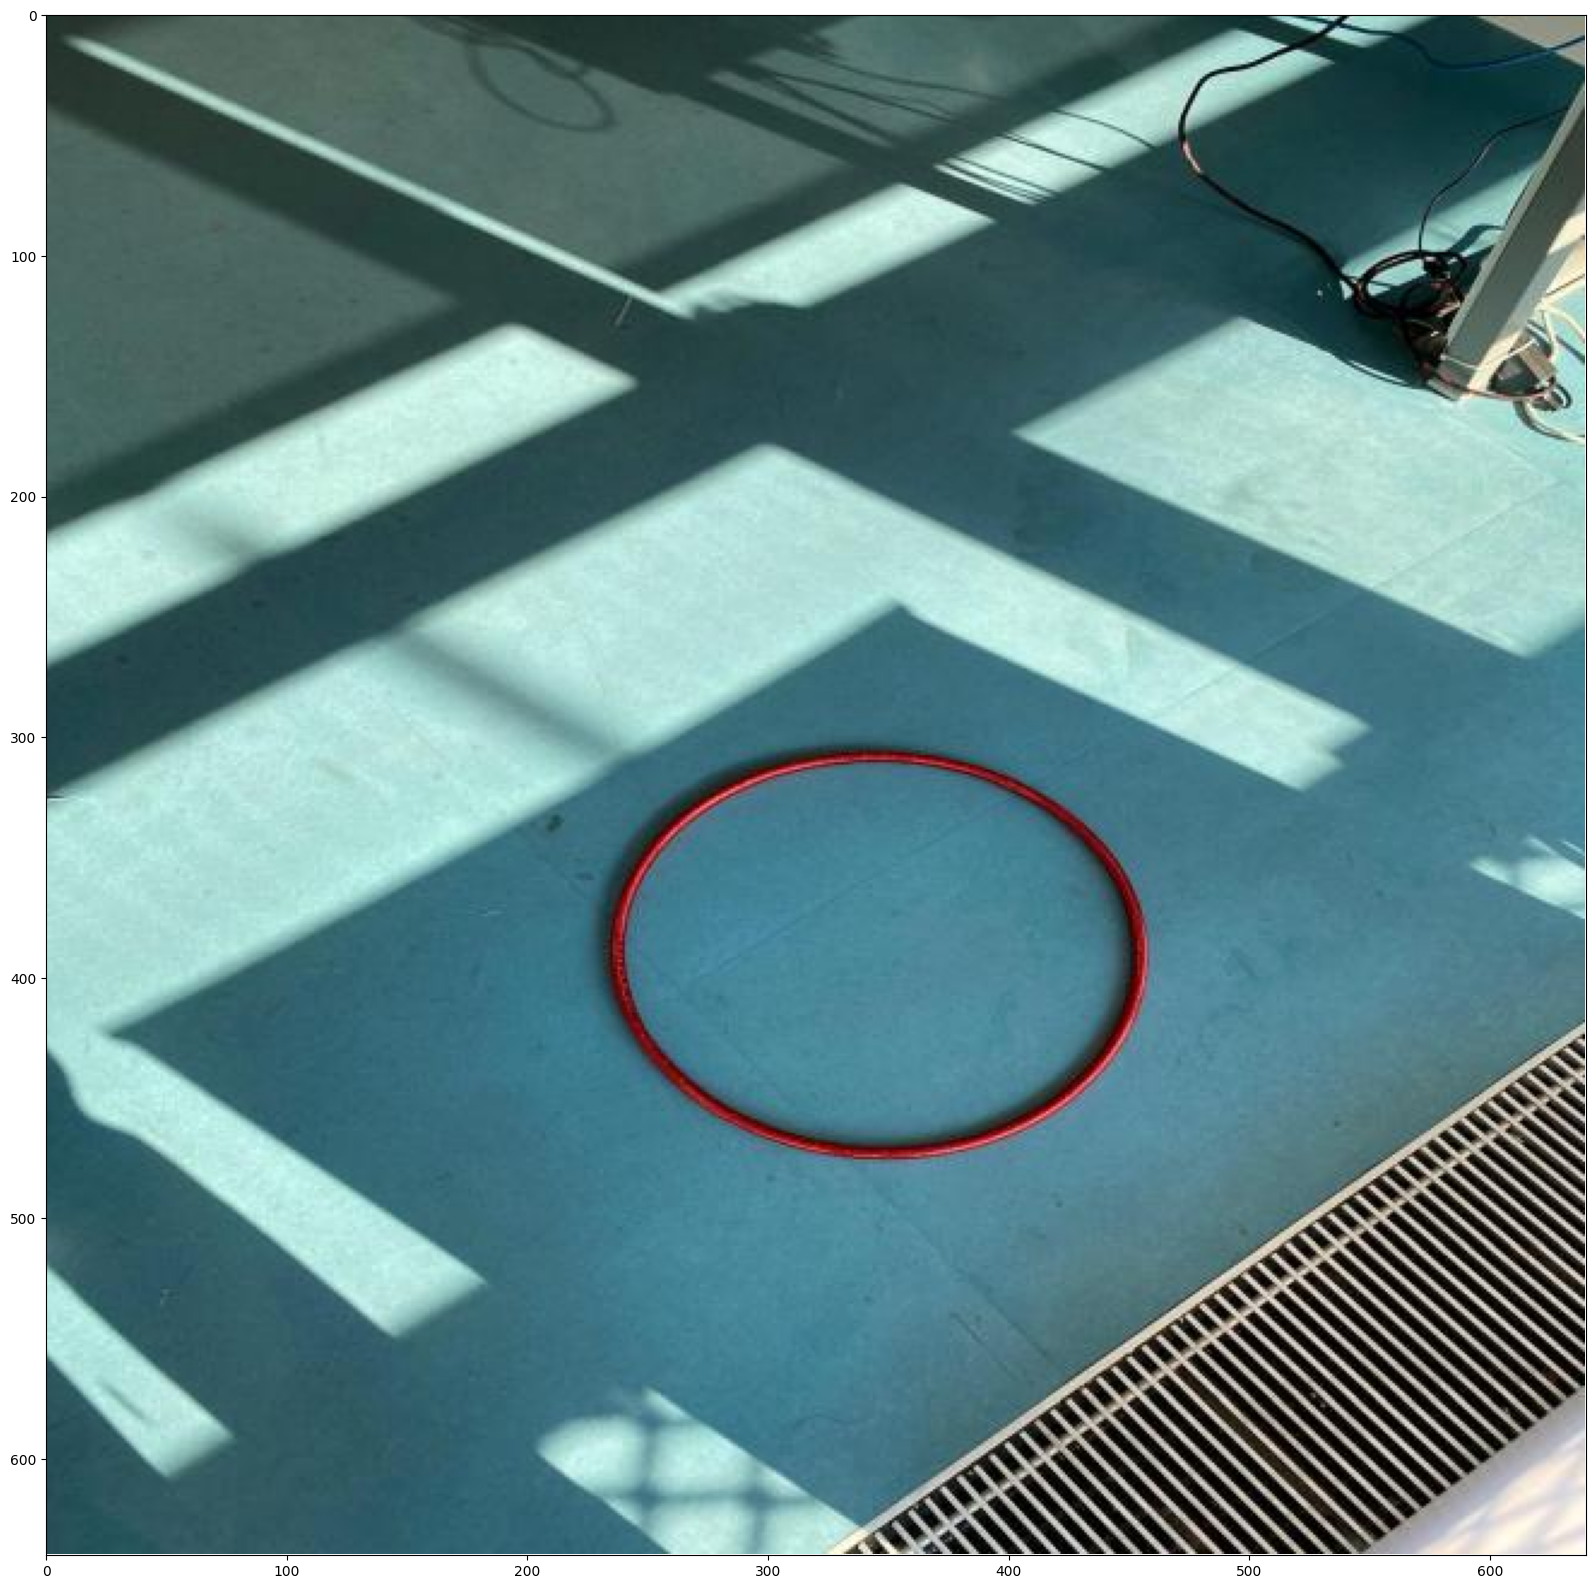

In [19]:
from ultralytics import YOLO
from bb_tools import show_bb
# Load the exported ONNX model
onnx_model = YOLO("runs/obb/train11/weights/best.pt")

# Run inference
results = onnx_model("test1.jpg", device="cpu")

# show results
for result in results:
    # xywhr = result.keypoints.xy  # center-x, center-y, width, height, angle (radians)
    xyxyxyxy = result.obb.xyxyxyxy  # polygon format with 4-points
    print(xyxyxyxy)
    show_bb("test2.jpg", xyxyxyxy[0])
    # names = [result.names[cls.item()] for cls in result.obb.cls.int()]  # class name of each box
    # confs = result.obb.conf  # confidence score of each box
    


## determine structure of onnx model

In [10]:
import onnx

training_run = 11

model = onnx.load(f"runs/obb/train{str(training_run)}/weights/best.onnx")

for input_tensor in model.graph.input:
    shape = input_tensor.type.tensor_type.shape
    dims = [dim.dim_value if dim.HasField("dim_value") else "dynamic" for dim in shape.dim]
    print(f"Input: {input_tensor.name}, Shape: {dims}")

Input: images, Shape: [1, 3, 640, 640]


## Convert from onnx to OpenVINO blob

In [11]:
import blobconverter

blob_path = blobconverter.from_onnx(
    model=f"runs/obb/train{str(training_run)}/weights/best.onnx",
    output_dir="converted_model",
    data_type="FP16",  # or FP32
    shaves=6           # number of SHAVEs (neural compute engines)
)

print(f"Blob saved to: {blob_path}")

{
    "exit_code": 1,
    "message": "Command failed with exit code 1, command: /opt/intel/openvino2022_1/tools/compile_tool/compile_tool -m /tmp/blobconverter/2e6879a1af94413386cbc886246a712b/best/FP16/best.xml -o /tmp/blobconverter/2e6879a1af94413386cbc886246a712b/best/FP16/best.blob -c /tmp/blobconverter/2e6879a1af94413386cbc886246a712b/myriad_compile_config.txt -d MYRIAD -ip U8",
    "stderr": "[ GENERAL_ERROR ] \n/home/jenkins/agent/workspace/private-ci/ie/build-linux-ubuntu20/b/repos/openvino/src/plugins/intel_myriad/graph_transformer/src/frontend/frontend.cpp:592 Failed to compile layer \"/model.23/Sin_output_0\": unsupported layer type \"Sin\"\n",
    "stdout": "OpenVINO Runtime version ......... 2022.1.0\nBuild ........... 2022.1.0-7019-cdb9bec7210-releases/2022/1\nNetwork inputs:\n    images : u8 / [...]\nNetwork outputs:\n    output0/sink_port_0 : f16 / [...]\n"
}


HTTPError: 400 Client Error: BAD REQUEST for url: https://blobconverter.luxonis.com/compile?version=2022.1&no_cache=False